[View in Colaboratory](https://colab.research.google.com/github/windpuppy/tensorflow/blob/master/stock_prediction.ipynb)

            Previous Day Price    High     Low    Last  Volume    hl_pct  \
Date                                                                       
2014-03-21              49.165  48.905  48.575  48.575     NaN  0.679362   
2014-03-24              48.575  48.990  45.825  46.750     NaN  4.791444   
2014-03-25              46.750  47.945  46.250  47.240     NaN  1.492379   
2014-03-26              47.240  47.295  43.850  43.980     NaN  7.537517   
2014-03-27              43.980  44.765  42.465  44.500     NaN  0.595506   

            pct_change  
Date                    
2014-03-21   -1.200041  
2014-03-24   -3.757077  
2014-03-25    1.048128  
2014-03-26   -6.900931  
2014-03-27    1.182356  
prediction length =  33
accuracy =  0.9399955076252271
[172.28046402 173.94213517 173.39474584 175.32710404 177.44457269
 175.02546375 175.38243811 176.78233205 179.52259238 182.04186925
 173.57981991 155.0331331  148.69372171 150.23927699 148.7944993
 151.71173547 152.42359343 161.07480618 

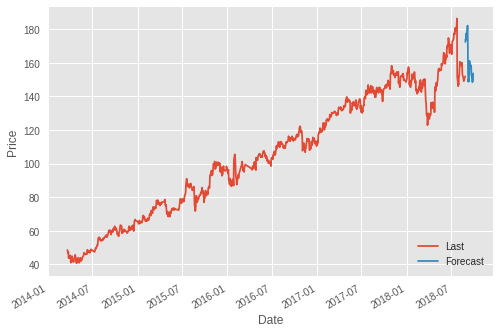

In [2]:
import pandas as pd
pd.__version__
!pip install quandl
import quandl, math, datetime
import numpy as np
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')

df = quandl.get("SSE/FB2A")
#print(df.head())

prediction_length = 0.03

df = df[['Previous Day Price', 'High', 'Low', 'Last', 'Volume']]
df['hl_pct'] = (df['High'] - df['Last']) / df['Last'] * 100.0
df['pct_change'] = (df['Last'] - df['Previous Day Price']) / df['Previous Day Price'] * 100.0
print(df.head())

df = df[['Last', 'hl_pct', 'pct_change', 'Volume']]
#print(df.head())

forecase_col = 'Last'
df.fillna(-9999, inplace=True)
forecast_out = int(math.ceil(prediction_length * len(df))) #10% of data out for prediction length
print("prediction length = ", forecast_out)

df['label'] = df[forecase_col].shift(-forecast_out)
#print(df.tail())

x = np.array(df.drop(['label'],1))
x = preprocessing.scale(x)
x = x[:-forecast_out]
x_future = x[-forecast_out:]

df.dropna(inplace=True)
y = np.array(df['label'])
y = np.array(df['label'])
#print(len(x), len(y))

# use 20% of data for testing, 80% for training
x_train, x_test, y_train, y_test = cross_validation.train_test_split(x, y, test_size=0.2)

# use linear regression as classifier
clf = LinearRegression(n_jobs=10)
#clf = svm.SVR()
clf.fit(x_train, y_train)
accuracy = clf.score(x_test, y_test)
print("accuracy = ", accuracy)

forecast_set = clf.predict(x_future)
print(forecast_set)

df['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
  next_date = datetime.datetime.fromtimestamp(next_unix)
  next_unix += one_day
  df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]
  
df['Last'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

